# Classification Modeling

In [1]:
import classifiers as clf

import pickle

import pandas as pd
import numpy  as np

from sklearn.model_selection import train_test_split
from imblearn.over_sampling  import SMOTE

import matplotlib.pyplot as plt
import seaborn           as sns
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings('ignore')

### Load Species Data

In [2]:
species = pd.read_pickle("../Data/species.pkl")
species.head()

,Scientific Name,Common Name,Federal Listing Status,Group_Amphibians,Group_Annelid Worms,Group_Arachnids,Group_Birds,Group_Clams,Group_Conifers and Cycads,Group_Corals,...,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,Accipiter gentilis,Northern goshawk,Not Listed,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Acipenser fulvescens,Lake sturgeon,Not Listed,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Acipenser oxyrinchus (=oxyrhynchus) desotoi,Atlantic sturgeon (Gulf subspecies),Threatened,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Agarodes alabamensis,[Unnamed] caddisfly,Not Listed,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Agrimonia incisa,Incised groovebur,Not Listed,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Set Target and Feature Variables

In [3]:
# Create target variables
y = species['Federal Listing Status']
y_labels = list(y.unique())

# Create target variables
X = species.drop(['Federal Listing Status', 'Scientific Name', 'Common Name'], axis = 1)

### Create Training and Test Sets

In [4]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# data set statistics
data_sets = pd.DataFrame({'Train':        y_train.value_counts(),
                          'Test':         y_test.value_counts(),
                          'Train Normal': y_train.value_counts() / y_train.count(),
                          'Test Normal':  y_test.value_counts()  / y_test.count()})

data_sets.loc['Total'] = data_sets.sum().astype(int)
data_sets

,Train,Test,Train Normal,Test Normal
Not Listed,7271,1769,0.774417,0.753407
Endangered,1487,412,0.158377,0.175468
Threatened,631,167,0.067206,0.071124
Total,9389,2348,1.000000,1.000000


### Classification Model Hyper Parameter Grid Search

In [5]:
# define parameter grid search for all classifiers
classifiers = []

# dummy classifier
classifiers.append(
    clf.grid_search_dummy_classifier(dict(
        strategy=['most_frequent','stratified'])))

# logistic regression
classifiers.append(
    clf.grid_search_logistic_regression(dict(
        C=[1e-2,1e0,1e2,1e6,1e12],
        penalty=['l1', 'l2'],
        fit_intercept=[True, False],
        multi_class=['ovr'],
        solver=['liblinear'])))

# gaussian naive bayes classifer

# k nearest neighbors classifier
classifiers.append(
    clf.grid_search_k_neighbors_classifier(dict(
        n_neighbors=[5,11],
        weights=['uniform', 'distance'],
        algorithm=['ball_tree','kd_tree'],
        leaf_size=[100,200])))

# decision tree classifier
classifiers.append(
    clf.grid_search_decision_tree_classifier(dict(
        criterion=['gini','entropy'],
        max_depth=[6,8],
        min_samples_leaf=[20,50,100],
        max_features=[20,30,40],
        min_impurity_decrease=[0.01,0.03,0.05])))

# random forest classifier
classifiers.append(
    clf.grid_search_random_forest_classifier(dict(
        n_estimators=[100,200,300],
        max_depth=[2,3,4],
        min_samples_leaf=[100,200],
        max_features=[10,20],
        min_impurity_decrease=[0.01,0.03,0.05])))

# ada boost classifer

### Baseline Classification Models

In [6]:
# run baseline dataset
baseline = clf.fit_predict_measure('Baseline', X_train, X_test, y_train, y_test, y_labels, classifiers)
baseline

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.6s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  3.3min finished


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0586s.) Setting batch_size=6.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 422 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 500 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:    9.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   49.6s
[Paralle

,Data,Classifier,Parameters,Split,Accuracy,Precision,Recall,F1 Score
0,Baseline,Dummy,{'strategy': 'most_frequent'},Train,0.774417,0.599722,0.774417,0.675965
1,Baseline,Dummy,{'strategy': 'stratified'},Train,0.634679,0.632821,0.629034,0.634266
2,Baseline,Dummy,{'strategy': 'most_frequent'},Test,0.753407,0.567622,0.753407,0.647451
3,Baseline,Logistic Regression,"{'C': 0.01, 'fit_intercept': True, 'multi_clas...",Train,0.774417,0.599722,0.774417,0.675965
4,Baseline,Logistic Regression,"{'C': 0.01, 'fit_intercept': True, 'multi_clas...",Train,0.774417,0.599722,0.774417,0.675965
5,Baseline,Logistic Regression,"{'C': 0.01, 'fit_intercept': False, 'multi_cla...",Train,0.774417,0.599722,0.774417,0.675965
6,Baseline,Logistic Regression,"{'C': 0.01, 'fit_intercept': False, 'multi_cla...",Train,0.785387,0.723093,0.785387,0.706459
7,Baseline,Logistic Regression,"{'C': 1.0, 'fit_intercept': True, 'multi_class...",Train,0.797423,0.733574,0.797423,0.735670
8,Baseline,Logistic Regression,"{'C': 1.0, 'fit_intercept': True, 'multi_class...",Train,0.797423,0.733643,0.797423,0.735712
9,Baseline,Logistic Regression,"{'C': 1.0, 'fit_intercept': False, 'multi_clas...",Train,0.797423,0.733574,0.797423,0.735670


In [29]:
baseline_test = baseline[baseline['Split'] == 'Test']
baseline_test.sort_values(by=['F1 Score'], ascending=False)

,Data,Classifier,Parameters,Split,Accuracy,Precision,Recall,F1 Score
40,Baseline,K Nearest Neighbors,"{'algorithm': 'ball_tree', 'leaf_size': 100, '...",Test,0.777683,0.733868,0.777683,0.716753
23,Baseline,Logistic Regression,"{'C': 100.0, 'fit_intercept': True, 'multi_cla...",Test,0.777257,0.712803,0.777257,0.711074
149,Baseline,Decision Tree,"{'criterion': 'gini', 'max_depth': 6, 'max_fea...",Test,0.772998,0.704861,0.772998,0.702755
2,Baseline,Dummy,{'strategy': 'most_frequent'},Test,0.753407,0.567622,0.753407,0.647451
258,Baseline,Random Forest,"{'max_depth': 2, 'max_features': 10, 'min_impu...",Test,0.753407,0.567622,0.753407,0.647451


### Handling Class Imbalance with SMOTE Oversampling

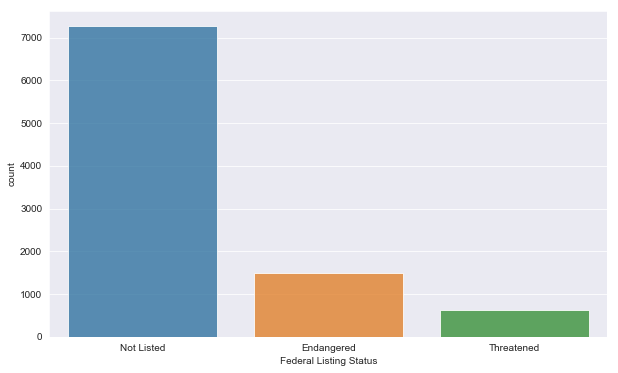

In [12]:
# plot class imbalance
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(y_train,
              order=y_train.value_counts().index,
              alpha=0.8)

In [9]:
keys = list(y_train.unique())
values = np.ones((3), dtype=int) * (y_train == 'Not Listed').sum()
sample_ratio = dict(zip(keys, values))
sample_ratio

{'Not Listed': 7271, 'Endangered': 7271, 'Threatened': 7271}

In [19]:
species['Federal Listing Status'].unique()

smote = SMOTE(ratio=sample_ratio)
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)

# balanced data set statistics
smote_sets = pd.DataFrame({'Train':        y_train_smote.value_counts(),
                           'Test':         y_test.value_counts(),
                           'Train Normal': y_train_smote.value_counts() / y_train_smote.count(),
                           'Test Normal':  y_test.value_counts()  / y_test.count()})

smote_sets.loc['Total'] = smote_sets.sum().astype(int)
smote_sets

# plot class imbalance
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(y_train_smote,
              order=y_train.value_counts().index,
              alpha=0.8)

KeyError: 'y_train_smote'

### Balanced Classification Models

In [11]:
# run balanced dataset
balanced = clf.fit_predict_measure('Balanced', X_train_smote, X_test, y_train_smote, y_test, y_labels, classifiers)
balanced

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   47.7s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 16.7min finished


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1653s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 300 tas

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.1min
[Paralle

,Data,Classifier,Parameters,Split,Accuracy,Precision,Recall,F1 Score
0,Balanced,Dummy,{'strategy': 'most_frequent'},Train,0.333333,0.111111,0.333333,0.166667
1,Balanced,Dummy,{'strategy': 'stratified'},Train,0.338055,0.334281,0.331866,0.331730
2,Balanced,Dummy,{'strategy': 'stratified'},Test,0.338586,0.620200,0.338586,0.398755
3,Balanced,Logistic Regression,"{'C': 0.01, 'fit_intercept': True, 'multi_clas...",Train,0.536469,0.575647,0.536469,0.512796
4,Balanced,Logistic Regression,"{'C': 0.01, 'fit_intercept': True, 'multi_clas...",Train,0.539357,0.577975,0.539357,0.518161
5,Balanced,Logistic Regression,"{'C': 0.01, 'fit_intercept': False, 'multi_cla...",Train,0.534589,0.569923,0.534589,0.512186
6,Balanced,Logistic Regression,"{'C': 0.01, 'fit_intercept': False, 'multi_cla...",Train,0.540503,0.576415,0.540503,0.519753
7,Balanced,Logistic Regression,"{'C': 1.0, 'fit_intercept': True, 'multi_class...",Train,0.598221,0.618133,0.598221,0.592462
8,Balanced,Logistic Regression,"{'C': 1.0, 'fit_intercept': True, 'multi_class...",Train,0.597121,0.616589,0.597121,0.591427
9,Balanced,Logistic Regression,"{'C': 1.0, 'fit_intercept': False, 'multi_clas...",Train,0.594462,0.613459,0.594462,0.589683


In [30]:
baseline_test = baseline[baseline['Split'] == 'Test']
baseline_test.sort_values(by=['F1 Score'], ascending=False)

,Data,Classifier,Parameters,Split,Accuracy,Precision,Recall,F1 Score
40,Baseline,K Nearest Neighbors,"{'algorithm': 'ball_tree', 'leaf_size': 100, '...",Test,0.777683,0.733868,0.777683,0.716753
23,Baseline,Logistic Regression,"{'C': 100.0, 'fit_intercept': True, 'multi_cla...",Test,0.777257,0.712803,0.777257,0.711074
149,Baseline,Decision Tree,"{'criterion': 'gini', 'max_depth': 6, 'max_fea...",Test,0.772998,0.704861,0.772998,0.702755
2,Baseline,Dummy,{'strategy': 'most_frequent'},Test,0.753407,0.567622,0.753407,0.647451
258,Baseline,Random Forest,"{'max_depth': 2, 'max_features': 10, 'min_impu...",Test,0.753407,0.567622,0.753407,0.647451


In [31]:
balanced_test = balanced[balanced['Split'] == 'Test']
balanced_test.sort_values(by=['F1 Score'], ascending=False)

,Data,Classifier,Parameters,Split,Accuracy,Precision,Recall,F1 Score
40,Balanced,K Nearest Neighbors,"{'algorithm': 'kd_tree', 'leaf_size': 100, 'n_...",Test,0.764906,0.712615,0.764906,0.718546
23,Balanced,Logistic Regression,"{'C': 1000000000000.0, 'fit_intercept': True, ...",Test,0.678024,0.730650,0.678024,0.700359
149,Balanced,Decision Tree,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",Test,0.652896,0.759012,0.652896,0.692844
258,Balanced,Random Forest,"{'max_depth': 3, 'max_features': 10, 'min_impu...",Test,0.635009,0.742019,0.635009,0.675036
2,Balanced,Dummy,{'strategy': 'stratified'},Test,0.338586,0.620200,0.338586,0.398755


### Data Loading

In [ ]:
baseline.to_pickle('../Data/baseline.pkl')
balanced.to_pickle('../Data/balanced.pkl')